## Access Data

In [10]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import os
folder_path = '/content/drive/My Drive/depth20_1000ms'

# List all files in the folder
file_list = os.listdir(folder_path)

print(f"Files in depth20_1000ms:")
for file_name in file_list:
    print(file_name)

Files in depth20_1000ms:
BNBFDUSD_20250315.txt
BNBFDUSD_20250314.txt
BNBFDUSD_20250317.txt
BNBFDUSD_20250316.txt


In [ ]:
import os
folder_path = '/content/drive/My Drive/aggTrade'

# List all files in the folder
file_list = os.listdir(folder_path)

print(f"Files in aggTrade:")
for file_name in file_list:
    print(file_name)

Files in aggTrade:
BNBFDUSD_20250315.txt
BNBFDUSD_20250317.txt
BNBFDUSD_20250314.txt
BNBFDUSD_20250316.txt


### Merging the aggTrade .txt files in aggTrade.csv file

In [ ]:

import pandas as pd
import glob

# Change this path to your folder containing .txt files
folder_path = '/content/drive/MyDrive/aggTrade'

os.chdir(folder_path)


# Get all .txt files in the current directory
txt_files = glob.glob("*.txt")

# Read and merge files (keeping only one header)
merged_df = pd.concat([pd.read_csv(f) for f in txt_files], ignore_index=True)

# Save as CSV
output_path = '/content/drive/MyDrive/aggTrade.csv'  # Change if needed
merged_df.to_csv(output_path, index=False)

print(f"Merged {len(txt_files)} files into: {output_path}")

In [ ]:
aggTradeFile = '/content/drive/MyDrive/aggTrade.csv'
aggTradedf = pd.read_csv(aggTradeFile)
aggTradedf.head()

### Merging the depth20_1000ms .txt files into depth20_1000ms.csv

In [ ]:



# Change this path to your folder containing .txt files
folder_path = '/content/drive/MyDrive/depth20_1000ms'

os.chdir(folder_path)


# Get all .txt files in the current directory
txt_files = glob.glob("*.txt")

# Read and merge files (keeping only one header)
merged_df = pd.concat([pd.read_csv(f) for f in txt_files], ignore_index=True)

# Save as CSV
output_path = '/content/drive/MyDrive/depth20_1000ms.csv'  # Change if needed
merged_df.to_csv(output_path, index=False)

print(f"Merged {len(txt_files)} files into: {output_path}")

In [ ]:
depth20_1000msFIle = '/content/drive/MyDrive/depth20_1000ms.csv'
depth20_1000msdf = pd.read_csv(depth20_1000msFIle)
depth20_1000msdf.head()

### Lets Begin Unsupervised Clustering

In [11]:
import pandas as pd
import numpy as np


depth_df = pd.read_csv('/content/drive/MyDrive/depth20_1000ms.csv')
aggTrade_df = pd.read_csv('/content/drive/MyDrive/aggTrade.csv')
# For aggTrade
# Strip ' IST' and ensure the string is clean
aggTrade_df['Time'] = aggTrade_df['Time'].str.replace(' IST', '', regex=False)

# Now parse using the datetime format
aggTrade_df['Time'] = pd.to_datetime(aggTrade_df['Time'], format='%Y-%m-%d %H:%M:%S.%f %z')

# Set index
aggTrade_df.set_index('Time', inplace=True)
# For depth20
depth_df['Time'] = depth_df['Time'].str.replace(' IST', '', regex=False)
depth_df['Time'] = pd.to_datetime(depth_df['Time'], format='%Y-%m-%d %H:%M:%S.%f %z')
depth_df.set_index('Time', inplace=True)
aggTrade_df.sort_index(inplace = True)
depth_df.sort_index(inplace = True)
print(depth_df.head())
print(aggTrade_df.head())

                                     BidPriceL20  BidQtyL20  BidPriceL19  \
Time                                                                       
2025-03-14 00:00:02.292522546+05:30       579.20      0.621       579.24   
2025-03-14 00:00:03.292828523+05:30       579.08      2.612       579.09   
2025-03-14 00:00:04.292889586+05:30       579.14      1.948       579.15   
2025-03-14 00:00:05.292551566+05:30       579.07      0.013       579.08   
2025-03-14 00:00:06.292725093+05:30       579.11      9.143       579.12   

                                     BidQtyL19  BidPriceL18  BidQtyL18  \
Time                                                                     
2025-03-14 00:00:02.292522546+05:30      0.015       579.25      0.009   
2025-03-14 00:00:03.292828523+05:30      8.606       579.10      3.453   
2025-03-14 00:00:04.292889586+05:30      3.957       579.18      1.681   
2025-03-14 00:00:05.292551566+05:30      0.013       579.09      8.606   
2025-03-14 00:00:06.292

In [12]:
features = pd.DataFrame(index=depth_df.index)

# Spread (Level 1)
features['spread'] = depth_df['AskPriceL1'] - depth_df['BidPriceL1']

# Microprice
features['microprice'] = (
    depth_df['BidPriceL1'] * depth_df['AskQtyL1'] + depth_df['AskPriceL1'] * depth_df['BidQtyL1']
) / (depth_df['BidQtyL1'] + depth_df['AskQtyL1'])

# Order Book Imbalance (Level 1)
features['imbalance_lvl1'] = (
    depth_df['BidQtyL1'] - depth_df['AskQtyL1']
) / (depth_df['BidQtyL1'] + depth_df['AskQtyL1'])

# Cumulative Bid/Ask Quantities
features['cum_bid_qty'] = depth_df[[f'BidQtyL{i}' for i in range(1, 21)]].sum(axis=1)
features['cum_ask_qty'] = depth_df[[f'AskQtyL{i}' for i in range(1, 21)]].sum(axis=1)

In [13]:
mid_price = (depth_df['BidPriceL1'] + depth_df['AskPriceL1']) / 2
features['mid_price'] = mid_price

# Log Return
features['log_return'] = np.log(mid_price / mid_price.shift(1))

# Rolling Volatility
features['vol_10s'] = features['log_return'].rolling(window=10).std()
features['vol_30s'] = features['log_return'].rolling(window=30).std()

In [14]:
# Cumulative volume (10s & 30s)
aggTrade_df['volume'] = aggTrade_df['Quantity']
volume_10s = aggTrade_df['volume'].rolling('10s').sum()
volume_30s = aggTrade_df['volume'].rolling('30s').sum()

# VWAP
aggTrade_df['vwap'] = (aggTrade_df['Price'] * aggTrade_df['Quantity']).cumsum() / aggTrade_df['Quantity'].cumsum()
aggTrade_df['vwap_shift'] = aggTrade_df['vwap'].diff()

# Resample and merge into features
volume_features = pd.DataFrame(index=features.index)
volume_features['cum_vol_10s'] = volume_10s.reindex(features.index, method='nearest')
volume_features['cum_vol_30s'] = volume_30s.reindex(features.index, method='nearest')
volume_features['vwap_shift'] = aggTrade_df['vwap_shift'].reindex(features.index, method='nearest')

features = features.join(volume_features)

In [15]:
features = features.dropna()
print(features.shape)

(338489, 12)


In [16]:

from sklearn.linear_model import LinearRegression


# 3. Key Advanced Features (optimized implementations)
def calculate_book_slope(side, levels=20):  # Reduced from 20 to 5 levels for speed
    slopes = np.zeros(len(depth_df))
    for i in range(len(depth_df)):
        prices = []
        cum_qty = 0
        cum_qtys = []
        for lvl in range(1, levels+1):
            price = depth_df[f'{side}PriceL{lvl}'].iloc[i]
            qty = depth_df[f'{side}QtyL{lvl}'].iloc[i]
            prices.append(price)
            cum_qty += qty
            cum_qtys.append(cum_qty)

        if side == 'Bid':
            prices = prices[::-1]
            cum_qtys = cum_qtys[::-1]

        if len(prices) > 1:
            model = LinearRegression().fit(np.array(cum_qtys).reshape(-1,1), prices)
            slopes[i] = model.coef_[0]
        else:
            slopes[i] = np.nan

    return pd.Series(slopes, index=depth_df.index)

# Calculate only the most important slopes
features['bid_slope_top5'] = calculate_book_slope('Bid', levels=5)
features['ask_slope_top5'] = calculate_book_slope('Ask', levels=5)

# 4. Essential Derived Features
features['vol_ratio_10s_30s'] = features['vol_10s'] / features['vol_30s'].replace(0, 1e-6)
features['price_jump'] = np.abs(features['log_return']) / features['vol_10s'].replace(0, 1e-6)

# 5. Time Features (simple and fast)
features['hour_of_day'] = features.index.hour
features['is_ny_open'] = ((features.index.hour >= 13) | (features.index.hour < 21)).astype(int)

# Cleanup
features = features.ffill().dropna()

print("Final features shape:", features.shape)
print(features.head())

Final features shape: (338489, 18)
                                     spread  microprice  imbalance_lvl1  \
Time                                                                      
2025-03-14 00:00:32.292399450+05:30    0.05  578.872979        0.319149   
2025-03-14 00:00:33.292424208+05:30    0.10  578.893207        0.064148   
2025-03-14 00:00:34.292682671+05:30    0.09  578.885000        0.000000   
2025-03-14 00:00:35.292878883+05:30    0.08  578.732231        0.055781   
2025-03-14 00:00:36.292334043+05:30    0.10  578.750132        0.602646   

                                     cum_bid_qty  cum_ask_qty  mid_price  \
Time                                                                       
2025-03-14 00:00:32.292399450+05:30       58.142       62.866    578.865   
2025-03-14 00:00:33.292424208+05:30       58.122       87.054    578.890   
2025-03-14 00:00:34.292682671+05:30       51.458       69.520    578.885   
2025-03-14 00:00:35.292878883+05:30       42.122       50.9

### Insights

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

#### Price Spread

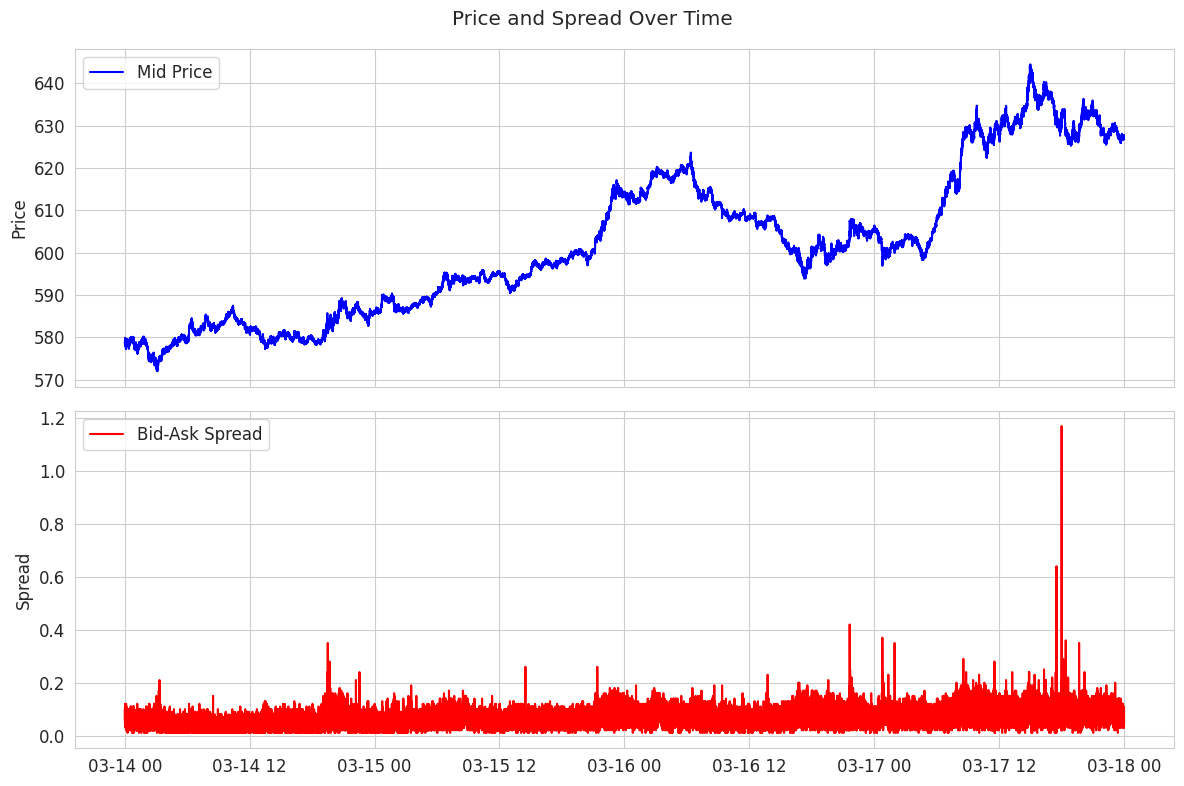

In [18]:


# Set up the plotting style
sns.set_style("whitegrid")  # or "darkgrid", "white", "dark", "ticks"
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['font.size'] = 12

# 1. Price and Spread Visualization
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.plot(features.index, features['mid_price'], label='Mid Price', color='blue')
ax1.set_ylabel('Price')
ax1.legend()
ax1.grid(True)

ax2.plot(features.index, features['spread'], label='Bid-Ask Spread', color='red')
ax2.set_ylabel('Spread')
ax2.legend()
ax2.grid(True)
plt.suptitle('Price and Spread Over Time')
plt.tight_layout()
plt.show()

#### Liquidity Features

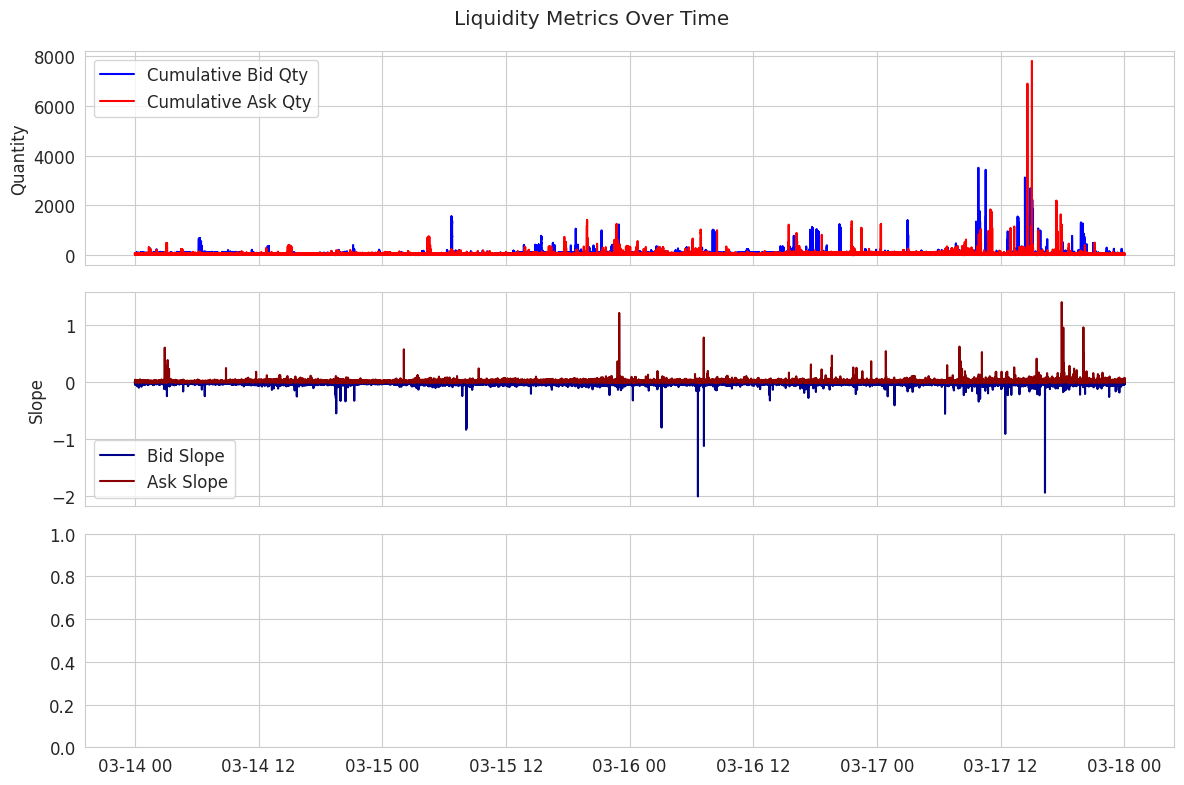

In [22]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True)
ax1.plot(features.index, features['cum_bid_qty'], label='Cumulative Bid Qty', color='blue')
ax1.plot(features.index, features['cum_ask_qty'], label='Cumulative Ask Qty', color='red')
ax1.set_ylabel('Quantity')
ax1.legend()
ax1.grid(True)

ax2.plot(features.index, features['bid_slope_top5'], label='Bid Slope', color='darkblue')
ax2.plot(features.index, features['ask_slope_top5'], label='Ask Slope', color='darkred')
ax2.set_ylabel('Slope')
ax2.legend()
ax2.grid(True)


plt.suptitle('Liquidity Metrics Over Time')
plt.tight_layout()
plt.show()

#### Volaitility Features

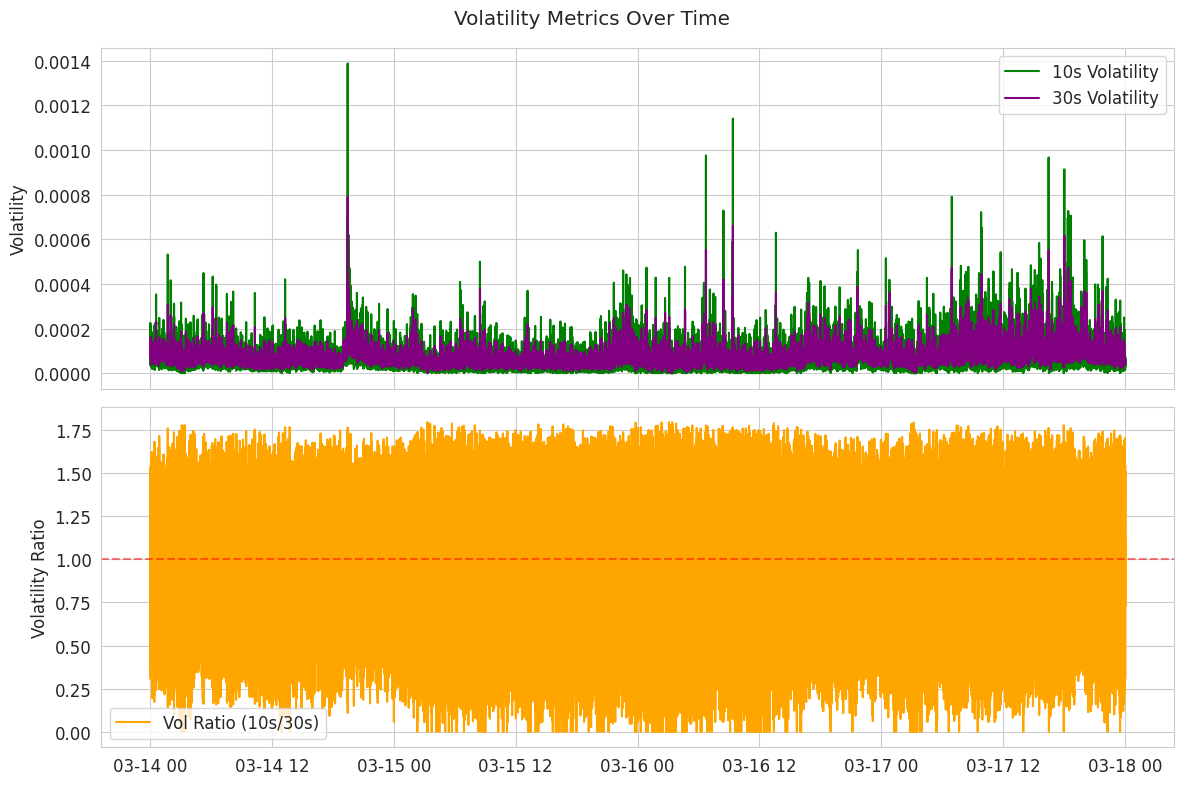

In [23]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.plot(features.index, features['vol_10s'], label='10s Volatility', color='green')
ax1.plot(features.index, features['vol_30s'], label='30s Volatility', color='purple')
ax1.set_ylabel('Volatility')
ax1.legend()
ax1.grid(True)

ax2.plot(features.index, features['vol_ratio_10s_30s'], label='Vol Ratio (10s/30s)', color='orange')
ax2.axhline(1, color='red', linestyle='--', alpha=0.5)
ax2.set_ylabel('Volatility Ratio')
ax2.legend()
ax2.grid(True)
plt.suptitle('Volatility Metrics Over Time')
plt.tight_layout()
plt.show()

#### Order Book Slope Analysis

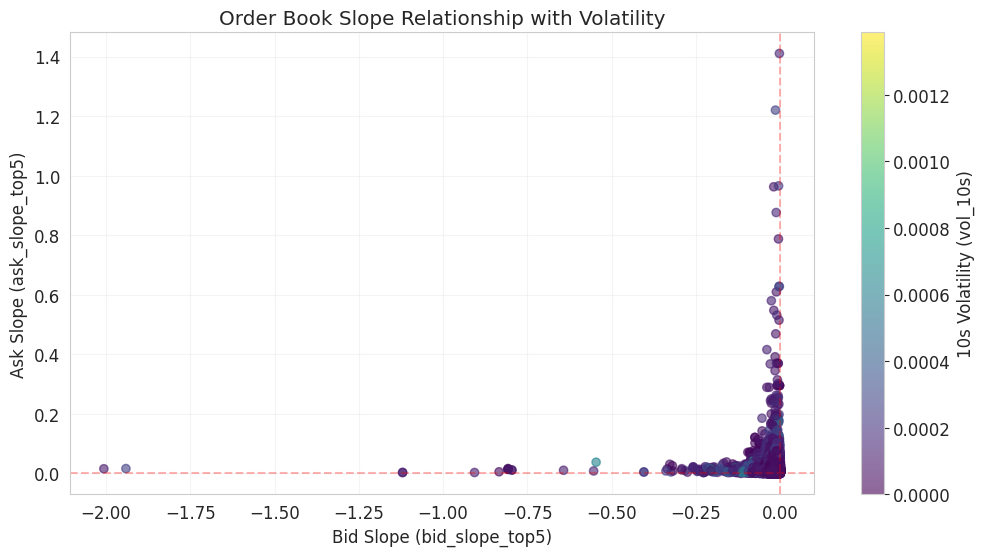

In [24]:
plt.figure(figsize=(12, 6))
plt.scatter(features['bid_slope_top5'], features['ask_slope_top5'],
            c=features['vol_10s'], cmap='viridis', alpha=0.6)
plt.colorbar(label='10s Volatility (vol_10s)')
plt.xlabel('Bid Slope (bid_slope_top5)')
plt.ylabel('Ask Slope (ask_slope_top5)')
plt.title('Order Book Slope Relationship with Volatility')
plt.axhline(0, color='red', linestyle='--', alpha=0.3)
plt.axvline(0, color='red', linestyle='--', alpha=0.3)
plt.grid(alpha=0.2)
plt.show()

#### Volatility Ratio vs Price Jumps

<Figure size 1000x600 with 0 Axes>

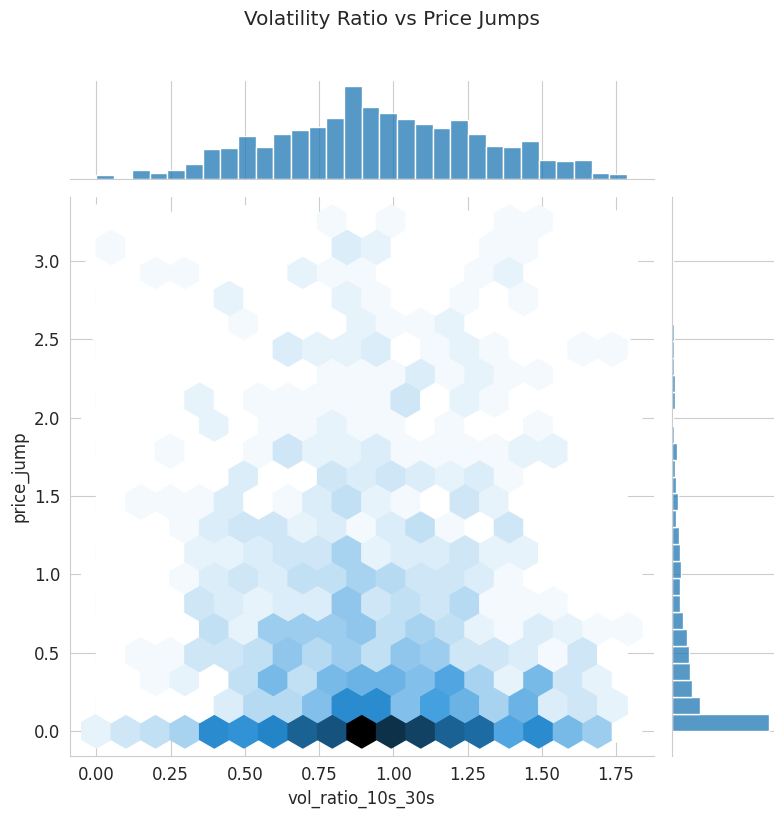

In [25]:
plt.figure(figsize=(10, 6))
sns.jointplot(x='vol_ratio_10s_30s', y='price_jump',
              data=features.sample(1000),
              kind='hex',
              height=8,
              marginal_kws={'bins': 30})
plt.suptitle("Volatility Ratio vs Price Jumps", y=1.02)
plt.tight_layout()
plt.show()

## Normalization

In [21]:
print(features.columns)

Index(['spread', 'microprice', 'imbalance_lvl1', 'cum_bid_qty', 'cum_ask_qty',
       'mid_price', 'log_return', 'vol_10s', 'vol_30s', 'cum_vol_10s',
       'cum_vol_30s', 'vwap_shift', 'bid_slope_top5', 'ask_slope_top5',
       'vol_ratio_10s_30s', 'price_jump', 'hour_of_day', 'is_ny_open'],
      dtype='object')


In [26]:
from sklearn.preprocessing import StandardScaler


# Assuming your features DataFrame is already loaded
scaler = StandardScaler()

# Fit and transform the data
scaled_array = scaler.fit_transform(features)

# Convert the scaled array back into a DataFrame with original column names
normalized_features = pd.DataFrame(scaled_array, columns=features.columns)

# (Optional) View a few rows
print(normalized_features.head())

     spread  microprice  imbalance_lvl1  cum_bid_qty  cum_ask_qty  mid_price  \
0 -0.815903   -1.325037        0.839669    -0.070263     0.005689  -1.325528   
1  1.036978   -1.323871        0.198479    -0.070468     0.282677  -1.324087   
2  0.666402   -1.324344        0.037181    -0.138512     0.081887  -1.324375   
3  0.295826   -1.333147        0.177440    -0.233841    -0.130744  -1.333306   
4  1.036978   -1.332115        1.552512    -0.213327    -0.111356  -1.333883   

   log_return   vol_10s   vol_30s  cum_vol_10s  cum_vol_30s  vwap_shift  \
0   -0.195681  1.688116  0.893400     0.135995     1.685242   -2.561206   
1    0.479831  1.631383  0.874767     0.180561     1.701753  -13.636106   
2   -0.099176  0.452092  0.868714    -0.031740     1.591329   -9.583714   
3   -2.994579  1.085549  1.027074     0.072193     1.631944   -4.158243   
4   -0.195729  1.081071  1.021827     0.179166     1.683312  -14.904906   

   bid_slope_top5  ask_slope_top5  vol_ratio_10s_30s  price_jump  ho

### Dimensionality Reduction

In [27]:
from sklearn.decomposition import PCA




# Step 1: Reduce dimensionality with PCA (keep 93% variance)
pca = PCA(n_components=0.93, random_state=42)
reduced_features = pca.fit_transform(normalized_features)

# Optional: print variance explained
print(f"PCA reduced from {normalized_features.shape[1]} to {reduced_features.shape[1]} components.")



PCA reduced from 18 to 13 components.


### Autoencoders for feature extraction

In [28]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam


input_dim = reduced_features.shape[1]
encoding_dim = 16

# Build autoencoder
input_layer = Input(shape=(input_dim,))
encoded = Dense(32, activation='relu')(input_layer)
encoded = Dense(encoding_dim, activation='relu')(encoded)

decoded = Dense(32, activation='relu')(encoded)
decoded = Dense(input_dim, activation='linear')(decoded)

autoencoder = Model(inputs=input_layer, outputs=decoded)
encoder = Model(inputs=input_layer, outputs=encoded)

autoencoder.compile(optimizer=Adam(1e-3), loss='mse')
autoencoder.fit(reduced_features, reduced_features, epochs=50, batch_size=32, shuffle=True, verbose=0)

# Get deep features
deep_features = encoder.predict(reduced_features)


10578/10578 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step


## Tranining the cluster model

### GMM

In [33]:
from sklearn.mixture import GaussianMixture

# Assuming encoded_features is your output from autoencoder
gmm = GaussianMixture(n_components=3, covariance_type='full', random_state=42)
gmm_labels = gmm.fit_predict(reduced_features)


#### Plot the cluster


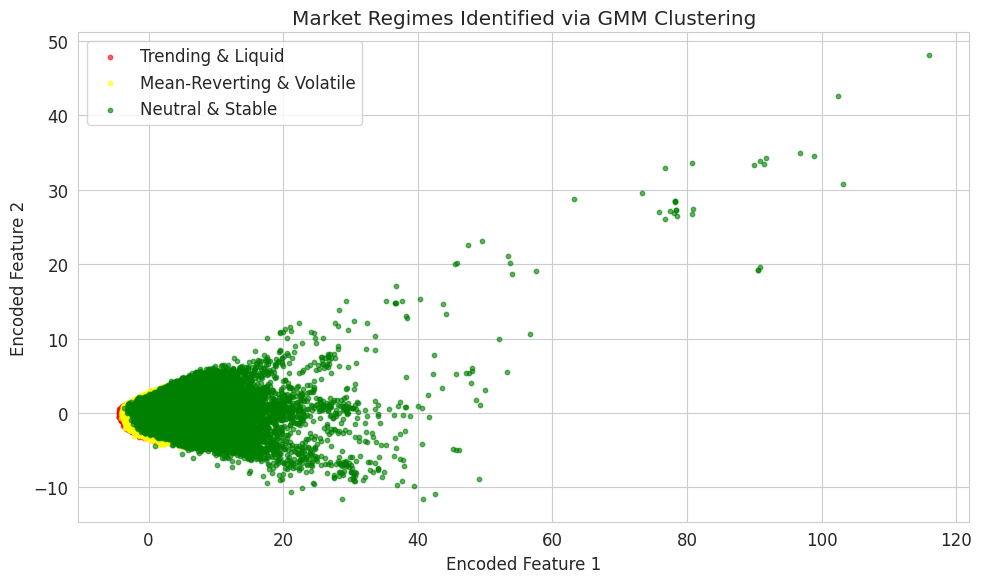

In [50]:

pca_vis = PCA(n_components=2)
encoded_2d = pca_vis.fit_transform(deep_features)



# Custom regime names
regime_names = ["Trending & Liquid", "Mean-Reverting & Volatile", "Neutral & Stable"]
# Custom colors: red, yellow, green
colors = ["red", "yellow", "green"]

plt.figure(figsize=(10, 6))
for i in range(3):
    plt.scatter(encoded_2d[gmm_labels == i, 0],
                encoded_2d[gmm_labels == i, 1],
                s=10, alpha=0.6,
                label=regime_names[i],
                color=colors[i])

plt.title("Market Regimes Identified via GMM Clustering")
plt.xlabel("Encoded Feature 1")
plt.ylabel("Encoded Feature 2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
|

#### HBDSAN

In [38]:
!pip install hdbscan

In [39]:
import hdbscan

# Run HDBSCAN on deep features
clusterer = hdbscan.HDBSCAN(min_cluster_size=100, min_samples=10)
hdbscan_labels = clusterer.fit_predict(deep_features)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [40]:

pca_2d = PCA(n_components=2)
features_2d = pca_2d.fit_transform(deep_features)

In [43]:
print("Unique cluster labels (excluding noise):", np.unique(filtered_labels))


Unique cluster labels (excluding noise): [0 1 2 3 4 5]


<ipython-input-52-141da00e74b2>:38: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


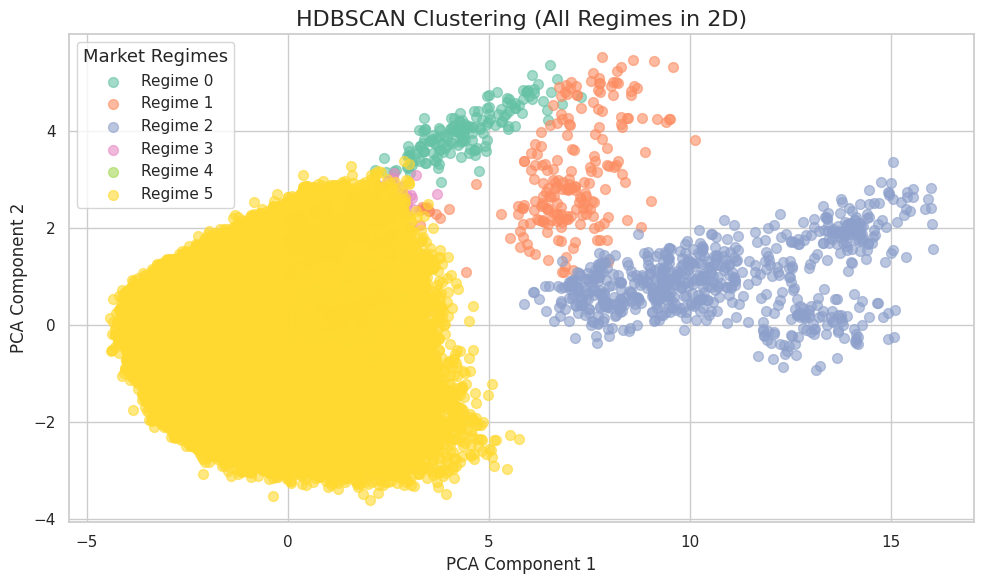

In [52]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Set Seaborn style for better aesthetics
sns.set(style="whitegrid")

# Step 1: Filter out noise (-1 label)
mask = hdbscan_labels != -1
filtered_features = features_2d[mask]
filtered_labels = hdbscan_labels[mask]

# Step 2: Get unique clusters (excluding noise)
unique_labels = np.unique(filtered_labels)

# Regime names and colors for all clusters
regime_map = {i: f'Regime {i}' for i in unique_labels}  # Auto-label regimes
color_palette = sns.color_palette("Set2", n_colors=len(unique_labels))  # Using Seaborn color palette

# Step 3: Plot for all regimes (5 regimes)
plt.figure(figsize=(10, 6))
for regime_id in unique_labels:
    if regime_id == -1:  # Skip noise points
        continue
    idx = filtered_labels == regime_id
    plt.scatter(filtered_features[idx, 0], filtered_features[idx, 1],
                c=[color_palette[regime_id]], label=regime_map[regime_id], s=50, alpha=0.6)

# Title and labels
plt.title('HDBSCAN Clustering (All Regimes in 2D)', fontsize=16)
plt.xlabel('PCA Component 1', fontsize=12)
plt.ylabel('PCA Component 2', fontsize=12)
plt.legend(title='Market Regimes', title_fontsize=13, fontsize=11)
plt.grid(True)

# Tight layout to adjust elements
plt.tight_layout()
plt.show()
